In [142]:
import tiktoken
import torch
import torch.nn as nn
from torch.nn import functional as F
device = 'mps'

In [144]:
device

'mps'

In [150]:
with open('tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [152]:
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [154]:
chars = sorted(list(set(text)))

In [156]:
stoi = { c:i for i, c in enumerate(chars)}
itos = { i:c for i, c in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join(itos[i] for i in l)

In [158]:
enc = tiktoken.encoding_for_model("gpt2")
assert enc.decode(enc.encode('Hello World')) == 'Hello World'

In [160]:
data = torch.tensor(encode(text), dtype=torch.long)
data[:100]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])

In [162]:
vocab_size = len(chars)

In [164]:
enc.decode(list(data[:100]))

'3PYZ["0P[PaLU+!/LMVYL"^L"WYVJLLK"HU`"M\\Y[OLY\'"OLHY"TL"ZWLHR)!!.SS+!@WLHR\'"ZWLHR)!!3PYZ["0P[PaLU+!FV\\'

In [166]:
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]


In [168]:
block_size = 5
x = train_data[7:block_size+7]
y = train_data[8:block_size + 8]
for i in range(block_size):
    context = x[:i + 1]
    target = y[i]
    print('______________________')
    print(f'When the context is || {context} || the target is || {target} ||')
    print(f'When the context is || {enc.decode(context.numpy())} || the target is || {enc.decode([target.item()])} ||')

______________________
When the context is || tensor([47]) || the target is || 58 ||
When the context is || P || the target is || [ ||
______________________
When the context is || tensor([47, 58]) || the target is || 47 ||
When the context is || P[ || the target is || P ||
______________________
When the context is || tensor([47, 58, 47]) || the target is || 64 ||
When the context is || P[P || the target is || a ||
______________________
When the context is || tensor([47, 58, 47, 64]) || the target is || 43 ||
When the context is || P[Pa || the target is || L ||
______________________
When the context is || tensor([47, 58, 47, 64, 43]) || the target is || 52 ||
When the context is || P[PaL || the target is || U ||


In [186]:
torch.manual_seed(43)

batch_size = 4
block_size = 4

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device) 
    return x, y

In [188]:
xb, yb = get_batch(train_data)

In [174]:
xb 

tensor([[58, 47, 44, 63],
        [43, 52,  1, 58],
        [32, 21, 31, 32],
        [ 1, 51, 53, 53]])

In [273]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
    def forward(self, idx, targets=None):
        logits = self. token_embedding_table(idx)

        if targets is None:
            loss=None
        else:
            B, T, C  = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :] 
            probs = F.softmax(logits, dim=-1) 
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

m = BigramLanguageModel(vocab_size)
model = m.to(device)
logits, loss = model(xb, yb)
print(logits.shape) 
print(loss)
print(decode(model.generate(idx = torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=100)[0].tolist()))

torch.Size([256, 65])
tensor(4.7225, device='mps:0', grad_fn=<NllLossBackward0>)

mZ:phazL'?hVe;'jEw'jtsna&aog&xaOR;QzwXpr?hlj.-lOb?tBI;E,wRJnrj-.pZbcI?TuWPUjfHphWG:wkz!---LdlGlQ &vl


In [274]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-2)

In [275]:
total_loss = []
batch_size = 64
iterations = 
for steps in range(iterations):

    xb, yb = get_batch('train')

    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    total_loss.append(loss.item())


In [276]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=500)[0].tolist()))


ES: ld, ouprd , asiavers

Maleerd che seatoty,
RCsemay bo d dust Red ntore. st 'st
FFdarean turms iCatheret khe 's ld, ghe y ve oumD:
JUMzaro breDO: hain w,


An mes's.
T:
3XTher, bund u wionguleroos hathande weritet k, y alematw 'd, t mallonowetandethere led d t,
A om,
MNTEENIwebe:
ToroourizKEN kowe gay beir, f whr may stetlou reryim,vethwitllidNsZAPoavendimy st dinon yof id ms't p s s the e orein t o Tghars, bo o te cee cl aras t my btr,--four eriotyooworileves st seyoveniketo,-n or lyore, n h


In [279]:
import matplotlib.pyplot as plt
plt.style.use('bmh')

Text(0.5, 1.0, 'Log Loss')

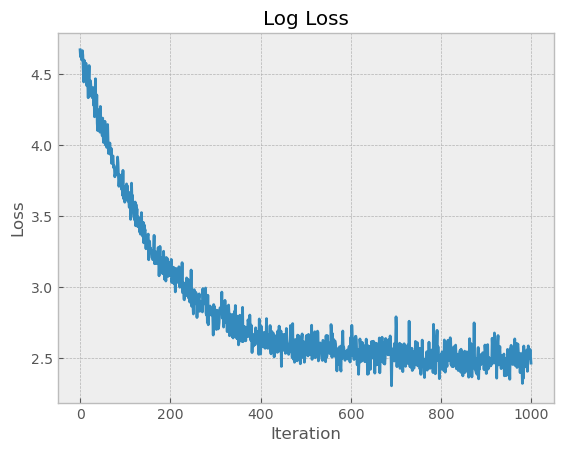

In [280]:
plt.plot([i for i in range(iterations)], total_loss)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title('Log Loss')